# IMDB

In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai.callbacks import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [0]:
# default path from above TextDataBunch
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
data_lm = load_data(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its xxunk short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject ,",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj xxunk xxmaj xxunk ' "" xxmaj la xxmaj xxunk , """,positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk xxunk experience in general . xxmaj with graphics",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [0]:
data.train_ds[0][0]

Text xxbos i really do n't get how people made this film and thought it was worth all the work they put into it . xxmaj even more xxunk are those who watched this film without feeling cheated out of xxunk minutes of doing something valuable like xxunk under the couch or reading xxmaj xxunk . 

 xxmaj first of all , surely they could have 2 found real xxmaj irish people , and some good - looking women who could deliver their lines better than the washed up , xxunk porn stars sprinkled throughout this film . xxmaj granted , the gore xxunk but strangely , it 's not as xxunk as you might think to see organs xxunk out of the porn stars ' hot ( xxunk ) tight bodies left and right . xxmaj probably has something to do with the fact that after their horrific xxunk acting you just want them to die in pain . 

 xxmaj so , if you do n't care at all about the following : 

 - acting ( seriously , everyone sucked . i 've never witnessed this before . xxup everyone sucked ) . 

 xxunk ( some crappy h

But the underlying data is all numbers

In [0]:
data.train_ds[0][0].data[:10]

array([  2,  18,  85,  60,  36,  98, 106, 102, 114,  20])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

### Download data

Data below is from kaggle

In [0]:
path = Config.data_path(); path

PosixPath('/root/.fastai/data')

In [0]:
path = '/root/.fastai/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c word2vec-nlp-tutorial -f labeledTrainData.tsv

 39% 5.00M/13.0M [00:00<00:00, 14.0MB/s]
100% 13.0M/13.0M [00:00<00:00, 32.8MB/s]


In [0]:
!kaggle competitions download -c word2vec-nlp-tutorial -f testData.tsv

 71% 9.00M/12.6M [00:00<00:00, 81.6MB/s]
100% 12.6M/12.6M [00:00<00:00, 80.3MB/s]


In [0]:
!kaggle competitions download -c word2vec-nlp-tutorial -f unlabeledTrainData.tsv

 35% 9.00M/26.0M [00:00<00:00, 61.8MB/s]
100% 26.0M/26.0M [00:00<00:00, 103MB/s] 


In [0]:
!unzip unlabeledTrainData.tsv.zip

In [0]:
!rm labeledTrainData.tsv.zip testData.tsv.zip unlabeledTrainData.tsv.zip

In [0]:
train = pd.read_csv('/root/.fastai/data/labeledTrainData.tsv', sep='\t')
test = pd.read_csv('/root/.fastai/data/testData.tsv', sep='\t')
ul_train = pd.read_csv('/root/.fastai/data/unlabeledTrainData.tsv', sep='\t', error_bad_lines=False)
train.drop('sentiment', 1, inplace=True)

all = pd.concat([train, test, ul_train])
all.to_csv('/root/.fastai/data/all.csv', index=False)

b'Skipping line 43043: expected 2 fields, saw 3\n'


In [0]:
path = Config.data_path()
path.ls()

[PosixPath('/root/.fastai/data/testData.tsv'),
 PosixPath('/root/.fastai/data/unlabeledTrainData.tsv'),
 PosixPath('/root/.fastai/data/labeledTrainData.tsv')]

In [0]:
#os.chdir('/root/.fastai/data')
#os.chdir('/content/drive/My Drive/DL_projects/imdb')

Data below is from URLs.IMDB.

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

### Prepare databunch and train LM
The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the review lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs = 32

In [0]:
%%time
# for URLs.IMDB
np.random.seed(2019)
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

data_lm.save('data_lm.pkl')

CPU times: user 32.5 s, sys: 10.4 s, total: 42.9 s
Wall time: 5min 42s


In [0]:
%%time
# for data from kaggle
np.random.seed(2019)
data_lm = TextLMDataBunch.from_csv(path, 'all.csv', valid_pct=0.1, text_cols=1, 
                                   bs=bs, max_vocab=40000, min_freq=5)

data_lm.save('data_lm.pkl')

CPU times: user 25.2 s, sys: 3.55 s, total: 28.8 s
Wall time: 5min 18s


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
path = Path('/content/drive/My Drive/DL_projects/imdb')

In [0]:
#data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,"was thrown out to give it effect . xxmaj this movie was not realistic at all . xxmaj it 's highly doubtful that the events that happened were true that evening when the "" xxmaj st. xxmaj francisville xxmaj experiment "" took place . i believe that the house may be haunted , but not on the night this movie was filmed ! xxmaj the ending was amusing when xxmaj"
2,"going to just go through a list of "" good "" and "" bad "" traits . \n\n xxmaj the xxmaj good : xxmaj lots of gorgeous people , especially the men . \n\n xxmaj the xxmaj bad : xxmaj lots of gorgeous people get munched by both the mutant xxmaj predator / xxmaj alien , and the xxmaj predator . \n\n xxmaj the xxmaj good : xxmaj an interesting"
3,"( most likely to save time and money ) . xxmaj in the movie , military helicopters ( true ) had to transfer the our babies ( xxup xxunk and xxup xxunk ) to xxup xxunk all the way to xxmaj xxunk ! xxmaj why you may ask , when we have the largest children 's hospital just down the street ? xxmaj because xxmaj texas xxmaj children 's xxmaj"
4,"then one of the girls decides that she "" loves "" the guy . xxmaj no , she just "" loves "" the way he makes her feel . xxmaj two of the girls are having fun with it , they think it is funny and no one seems to have any moral problems with what they are doing . xxmaj it just shameless , but yeah this is all"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.model_dir = '/content/drive/My Drive/DL_projects/imdb'

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(40003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(40003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=40003, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07


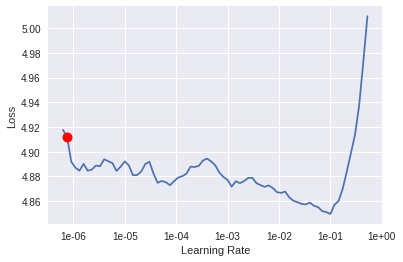

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))  # on google colab with Tesla K80

epoch,train_loss,valid_loss,accuracy
1,4.216609,4.075767,0.291847


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07


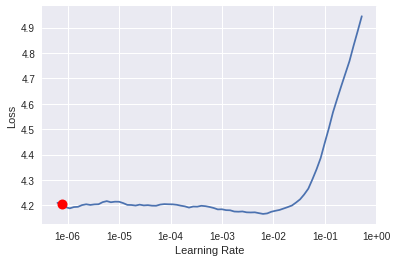

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit(6, 1e-3, callbacks=[SaveModelCallback(learn, name='fine_tuned')])

epoch,train_loss,valid_loss,accuracy
1,3.893548,3.808045,0.322495


Better model found at epoch 1 with val_loss value: 3.808044672012329.
Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
bs = 32

In [0]:
%%time
# for data from URLs.IMDB
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_class')

CPU times: user 16.1 s, sys: 3.91 s, total: 20.1 s
Wall time: 2min 49s


In [0]:
# for data from kaggle
train = pd.read_csv('/root/.fastai/data/labeledTrainData.tsv', sep='\t')
test = pd.read_csv('/root/.fastai/data/testData.tsv', sep='\t')

np.random.seed(2019)
msk = np.random.rand(len(train)) > 0.9
valid = train[msk]
train = train[~msk]

In [0]:
path = Path('/content/drive/My Drive/DL_projects/imdb')

In [0]:
%%time
# for data from kaggle
data_clas = TextClasDataBunch.from_df(path, train_df=train, valid_df=valid, test_df=test,
                                      vocab=data_lm.vocab, bs=bs,
                                      text_cols='review', label_cols='sentiment')

data_clas.save('data_class.pkl')

CPU times: user 10.9 s, sys: 1.81 s, total: 12.7 s
Wall time: 2min 36s


In [0]:
#data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas = load_data(path, 'data_class', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,1
"xxbos xxmaj in this excellent xxmaj twentieth - xxmaj century xxmaj fox film - noir , the metropolis is a labyrinth of despair in which xxunk and predators survive by living off one another . xxmaj brooding cityscapes lower over puny humanity in bleak expressionist symbolism . \n \n a prostitute has her purse snatched on the subway . xxmaj it contains a microfilm , and a communist spy",1
"xxbos xxmaj which do you think the average person would know more / less about : xxmaj iranian cinema or xxmaj iranian football ? xxmaj interestingly , the two come to the forefront of controversial xxmaj iranian filmmaker xxmaj jafar xxmaj panahi 's latest film entitled ' xxmaj offside ' , a tale that uses football or access to football as a backdrop for a series of scenes revolving around",1
"xxbos xxmaj when the xxmaj bourne xxmaj identity arrived five years ago i have to confess that i did n't think much of it . xxmaj at the time i was eleven years old , so perhaps i was too young to really get into the storyline and understand the whole scenario . xxmaj two years ago when the xxmaj bourne xxmaj supremacy arrived i thought it was a better",1
"xxbos xxmaj romance is in the air and love is in bloom in xxmaj victorian era xxmaj england , in this light - hearted story set against a society in a time in which manners were still in vogue , the ladies were charming and elegant , and the gentlemen dashing . ` xxmaj emma , ' based on the novel by xxmaj jane xxmaj austen and written for the",1


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.model_dir = '/content/drive/My Drive/DL_projects/imdb'

In [0]:
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02


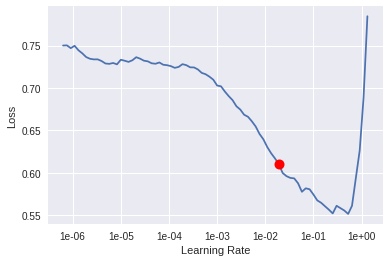

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.356549,0.225428,0.907146


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.281280,0.196824,0.915624


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.237195,0.176627,0.928543


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


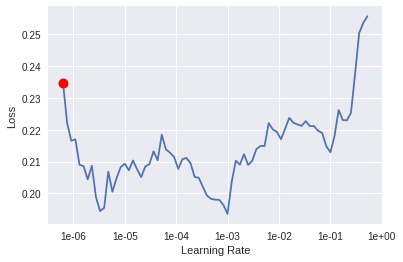

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, name='final-stage')])

epoch,train_loss,valid_loss,accuracy
1,0.235903,0.173288,0.928946
2,0.203677,0.165734,0.930561
3,0.197153,0.163580,0.931772
4,0.197304,0.164402,0.930965


In [0]:
learn.save('final-stage')

In [0]:
learn.load('final-stage');

In [0]:
learn.predict("I really loved that movie, it was awesome!")

(<fastai.core.Category at 0x7f0583a432e8>,
 tensor(1),
 tensor([1.8330e-05, 9.9998e-01]))

In [0]:
# to fix the data ordering problem (for kaggle submission), we add test again
data_clas.add_test(data_clas.test_ds)

In [0]:
# test set prediction
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
test_id = pd.read_csv('/root/.fastai/data/testData.tsv', sep='\t')['id'].values
submit = pd.DataFrame({'id':test_id, 'sentiment':preds[:,1].numpy()})
submit.to_csv('/content/drive/My Drive/DL_projects/imdb/submit.csv', index=False)

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/imdb')

In [0]:
!kaggle competitions submit -c word2vec-nlp-tutorial -f submit.csv -m "fastai transfer learning"

100% 452k/452k [00:05<00:00, 85.3kB/s]
Successfully submitted to Bag of Words Meets Bags of Popcorn

In [0]:
# local test
from sklearn.metrics import accuracy_score, roc_auc_score
y_test = pd.read_csv('/content/drive/My Drive/DL_projects/imdb/test_labels.csv')
ytest = y_test['sentiment'].values
ptest = preds[:,1].numpy()
ptest_ = (ptest>=0.5).astype('uint8')
accuracy_score(ytest, ptest_), roc_auc_score(ytest, ptest)

(0.93996, 0.9855294496000001)